In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
import pqr

# Загрузка и предобработка данных

In [3]:
prices = pd.read_excel('factors/russia/monthlyprice.xlsx', index_col=0, parse_dates=True)
mcap = pd.read_excel('factors/russia/mcap.xlsx', index_col=0, parse_dates=True)
volume = pd.read_excel('factors/russia/betafilter.xlsx', index_col=0, parse_dates=True)
imoex = pd.read_excel('factors/russia/imoex.xlsx', index_col=0, parse_dates=True)

for df in (prices, mcap, volume, imoex):
    df.replace(0, np.nan, inplace=True)

# Настраиваем окружение - Юниверс, Бенчмарк и факторы

In [4]:
universe = pqr.Universe(prices)
universe.filter(volume >= 10_000_000)

factorizer = pqr.Factorizer(
    pqr.Filter(universe),
    pqr.agg.Mean(3),
    pqr.Hold(3),
)

size = factorizer(mcap, better="less")

benchmark = pqr.Benchmark.from_index(imoex["IMOEX"], name="IMOEX")

# 1 способ использования: строим факторную модель

Данный способ хорошо подходит для первичного анализа фактора и научных исследований наличия факторов на том или ином рынке.

Сначала построим одну модель с параметрами 3-0-3

In [5]:
builder = pqr.PortfolioBuilder(
    pqr.EqualWeights(),
    pqr.TheoreticalAllocation()
)

fm = pqr.fm.FactorModel(
    picking_strategies=[
        pqr.fm.Quantiles(0, 1/3),
        pqr.fm.Quantiles(1/3, 2/3),
        pqr.fm.Quantiles(2/3, 1),
    ],
    portfolio_builder=builder,
    add_wml=True
)

portfolios = fm(size, universe)

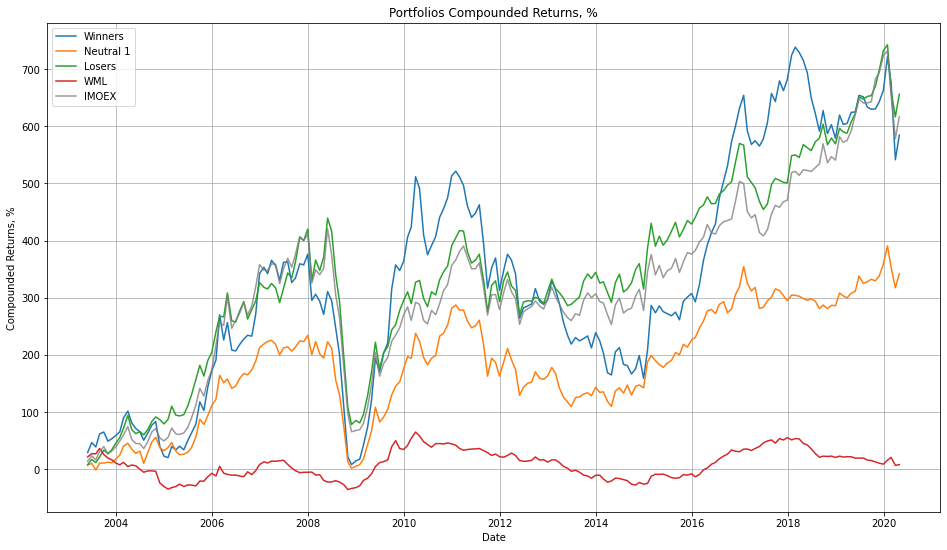

,Winners,Neutral 1,Losers,WML
"Total Return, %",584.57,341.99,656.05,7.83
"CAGR, %",11.98,9.14,12.64,0.44
"Mean Return, %",17.16** (2.09),12.32** (1.93),14.90*** (2.57),2.26 (0.48)
"Volatility, %",33.85,26.29,23.91,19.27
"Win Rate, %",57.35,59.80,60.78,49.02
"Mean Turnover, %",193.87,184.63,86.99,280.86
"Maximum Drawdown, %",-77.35,-69.62,-66.99,-56.29
"Value at Risk, %",-45.97,-35.07,-35.16,-24.75
"Expected Tail Loss, %",-68.53,-58.16,-54.74,-36.23
"Expected Tail Reward, %",86.74,60.83,49.92,48.92


In [6]:
summary = pqr.dash.SummaryDashboard(benchmark)
summary(portfolios)

## Поищем модель получше

Результаты получились не очень: ни один портфель не победил бенчмарк. Скорее всего, параметры подобраны неправильно, но вручную перебирать их может быть довольно-таки трудозатратно. К тому же, есть риск пропустить хорошую модель.

Поэтому воспользуемся перебором параметров.

In [7]:
def factorizer_mean_factory(looking, lag, holding):
    return pqr.Factorizer(
        pqr.Filter(universe),
        pqr.agg.Mean(looking),
        pqr.Lag(lag),
        pqr.Hold(holding)
    )


param_grid = {
    "(1, 0, 1)": factorizer_mean_factory(1, 0, 1),
    "(1, 1, 1)": factorizer_mean_factory(1, 1, 1),
    "(3, 0, 3)": factorizer_mean_factory(3, 0, 3),
    "(3, 1, 3)": factorizer_mean_factory(3, 1, 3),
    "(6, 0, 6)": factorizer_mean_factory(6, 0, 6),
    "(6, 1, 6)": factorizer_mean_factory(6, 1, 6),
    "(9, 0, 9)": factorizer_mean_factory(9, 0, 9),
    "(9, 1, 9)": factorizer_mean_factory(9, 1, 9),
    "(12, 0, 12)": factorizer_mean_factory(12, 0, 12),
    "(12, 1, 12)": factorizer_mean_factory(12, 1, 12),
}

gs = pqr.fm.GridSearch(
    factorizers=param_grid,
    factor_model=fm
)

size_raw = pqr.Factor(mcap, better="less")

results = gs(
    factor=size_raw,
    universe=universe,
    target=pqr.metrics.Alpha(benchmark)
)

In [8]:
results

,Winners,Neutral 1,Losers,WML
"(1, 0, 1)",-0.027737,0.050185,0.006562,-0.034298
"(1, 1, 1)",-0.042618,0.025561,0.008827,-0.051445
"(3, 0, 3)",-0.004132,-0.014993,0.010719,-0.014851
"(3, 1, 3)",-0.005768,-0.015552,0.009386,-0.015154
"(6, 0, 6)",-0.078820,0.035929,0.022508,-0.101328
"(6, 1, 6)",-0.076508,0.029243,0.023756,-0.100264
"(9, 0, 9)",-0.038129,0.037991,0.017645,-0.055773
"(9, 1, 9)",-0.043747,0.047719,0.014939,-0.058686
"(12, 0, 12)",-0.043771,0.060237,0.007768,-0.051539
"(12, 1, 12)",-0.042366,0.058143,0.006639,-0.049006


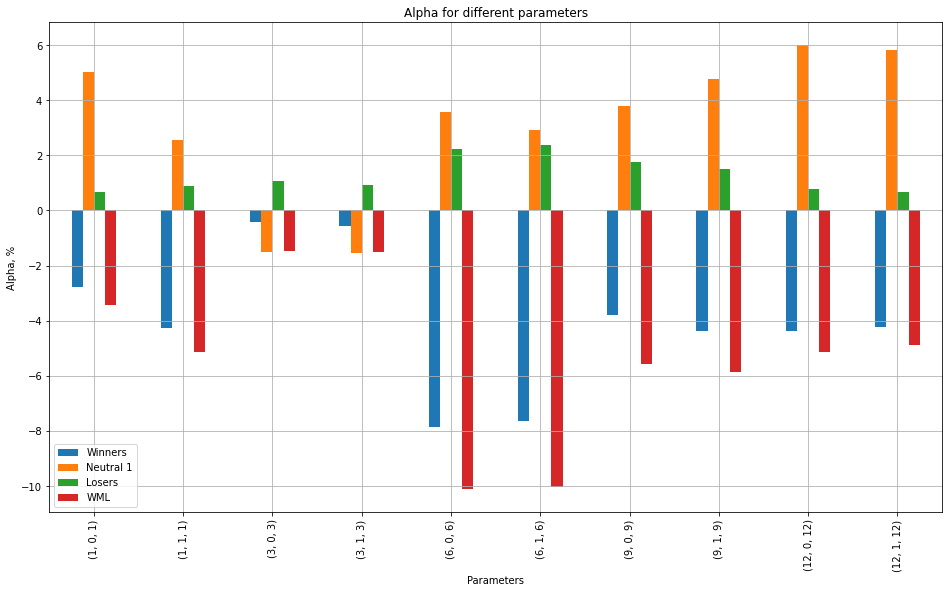

In [9]:
(results * 100).plot.bar()
plt.title("Alpha for different parameters")
plt.xlabel("Parameters")
plt.ylabel("Alpha, %")
plt.grid();

Видно, что лучшая модель с точки зрения WML имеет параметры (3, 1, 3), но лучший портфель - нейтральный с параметрами 12, 0, 12. Его и протестируем.

In [10]:
best_factorizer = param_grid["(12, 0, 12)"]
size_best = best_factorizer(mcap, better="less")

portfolios = fm(size_best, universe)

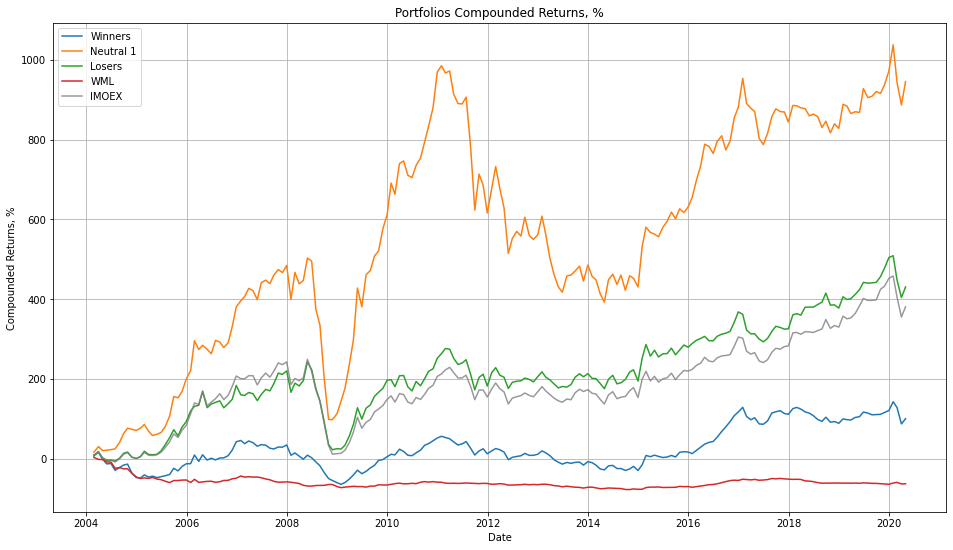

,Winners,Neutral 1,Losers,WML
"Total Return, %",99.85,945.36,430.26,-63.17
"CAGR, %",4.35,15.54,10.81,-5.96
"Mean Return, %",9.16 (1.18),18.50*** (2.67),13.52** (2.16),-4.36 (-0.94)
"Volatility, %",31.31,27.97,25.19,18.79
"Win Rate, %",55.38,55.90,62.05,49.23
"Mean Turnover, %",77.83,81.08,40.35,118.18
"Maximum Drawdown, %",-75.69,-67.21,-64.36,-78.40
"Value at Risk, %",-47.19,-30.40,-37.57,-29.29
"Expected Tail Loss, %",-65.63,-60.06,-55.16,-45.42
"Expected Tail Reward, %",73.98,70.38,57.04,40.47


In [11]:
summary(portfolios)

### Лучший портфель поподробнее

Шарп получился меньше 1, не очень впечатляет, но посмотрим поподробнее на данный портфель. После обучения модели все портфели сохраняются в список, нас интересует 2 элемент.

In [12]:
best_portfolio = portfolios[1]

Посмотрим на изменение годовой беты портфеля: видно, что в основном бета колеблется около 1, но в последние годы снизилась почти наполовину, при этом был скачок до более чем 1.6 в 2013 году

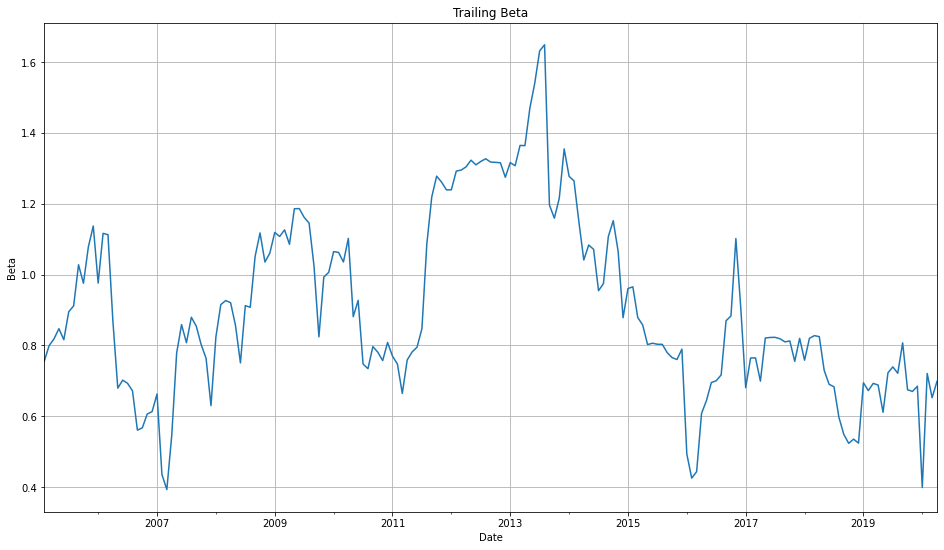

In [13]:
pqr.metrics.TrailingBeta(benchmark)(best_portfolio).plot()

plt.title("Trailing Beta")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.grid();

Годовой Шарп выглядит совсем непривлекательно - американские горки, но в некоторые моменты он доходил до 3.

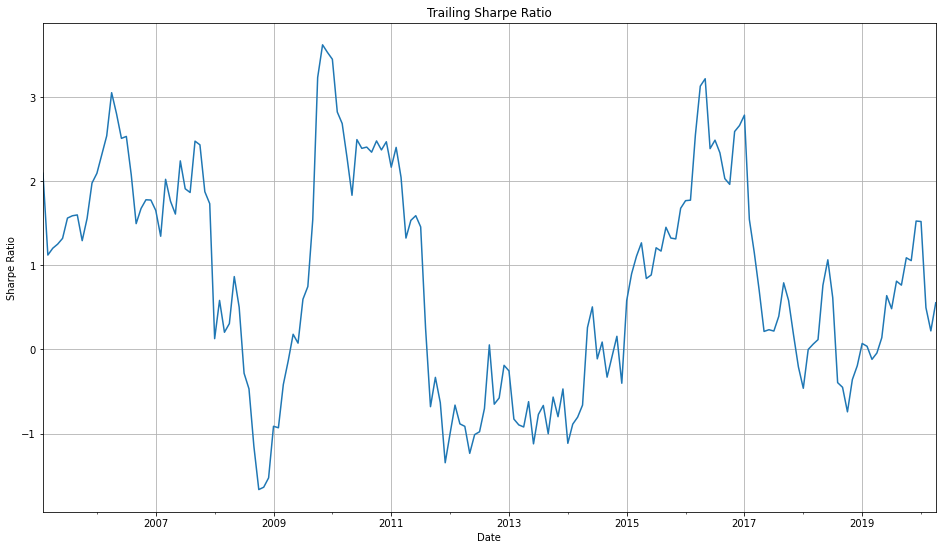

In [14]:
pqr.metrics.TrailingSharpeRatio()(best_portfolio).plot()

plt.title("Trailing Sharpe Ratio")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid();

Годовая просадка в целом не так ужасно выглядит, но в 2008 падение стоило бы почти всего портфеля, а в 2013-2014 была бы потеряна половина доходности портфеля.

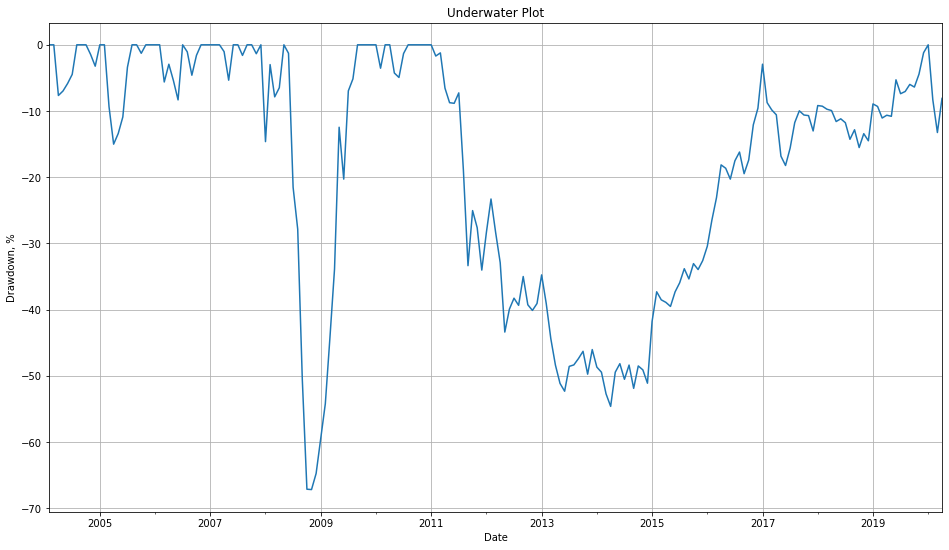

In [15]:
(pqr.metrics.Drawdown()(best_portfolio) * 100).plot()

plt.title("Underwater Plot")
plt.xlabel("Date")
plt.ylabel("Drawdown, %")
plt.grid();

# 2 способ использования: строим и настраиваем портфель

В примере выше мы хотели рассмотреть всего 1 портфель, для этого нам не было необходимости строить еще 2 дополнительных. Но данная глава нужна не только для того, чтобы облегчить расчеты, иногда нас может интересовать конкретный портфель, и мы хотим сконцентрироваться на его настройке. Ну или требуется более подробно изучить фактор.

Но для этого придется чуть больше погрузиться в библиотеку.

In [16]:
# создадим 2 стратегии отбора акций: топ-10 акций по фактору и топ 10% акций по фактору
top10 = pqr.fm.Top(10)
q01 = pqr.fm.Quantiles(0, 0.1)

In [17]:
# проинвестируем в оба в нашу изначальную стратегию 3-0-3
top10_portfolio = builder(
    universe,
    longs=top10(size),
    name="Top 10"
)


q01_portfolio = builder(
    universe,
    longs=q01(size),
    name="Top 10%"
)

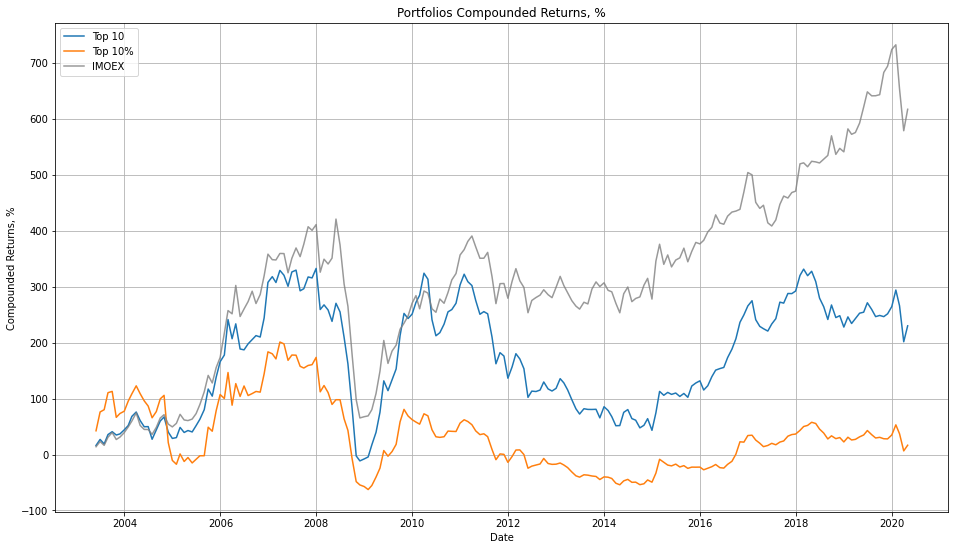

,Top 10,Top 10%
"Total Return, %",229.90,16.59
"CAGR, %",7.27,0.91
"Mean Return, %",12.68* (1.59),10.63 (0.99)
"Volatility, %",32.84,44.26
"Win Rate, %",57.35,50.49
"Mean Turnover, %",200.00,243.96
"Maximum Drawdown, %",-79.52,-87.58
"Value at Risk, %",-49.23,-59.64
"Expected Tail Loss, %",-71.04,-93.29
"Expected Tail Reward, %",77.18,117.32


In [18]:
summary([top10_portfolio, q01_portfolio])

Окей, возьмем в разработку портфель из топ-10 компаний по капитализации. Попробуем взвесить его по ней же, получится по сути своей смарт-бета портфель (за тем лишь исключением, что фактор размера мы используем в другую сторону:)).

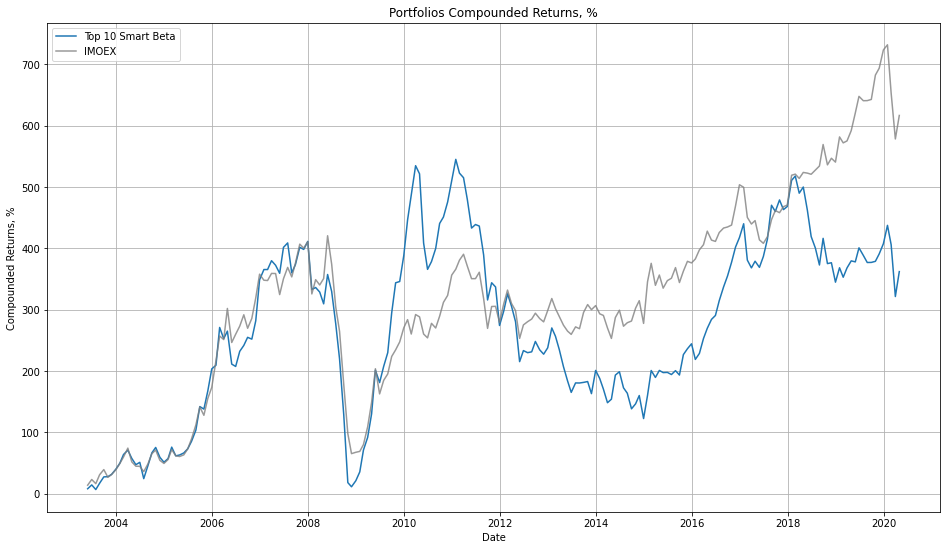

,Top 10 Smart Beta
"Total Return, %",362.18
"CAGR, %",9.42
"Mean Return, %",14.32** (1.87)
"Volatility, %",31.49
"Win Rate, %",59.80
"Mean Turnover, %",311.59
"Maximum Drawdown, %",-78.24
"Value at Risk, %",-49.98
"Expected Tail Loss, %",-69.64
"Expected Tail Reward, %",68.72


In [19]:
builder_smart_beta = pqr.PortfolioBuilder(
    pqr.WeightsByFactor(size),
    pqr.TheoreticalAllocation()
)

top10_portfolio_smart_beta = builder_smart_beta(
    universe,
    longs=top10(size),
    name="Top 10 Smart Beta"
)

summary([top10_portfolio_smart_beta])

Стало лучше, но все равно даже не догоняем бенчмарк. Попробуем применить обратный подход для взвешивания

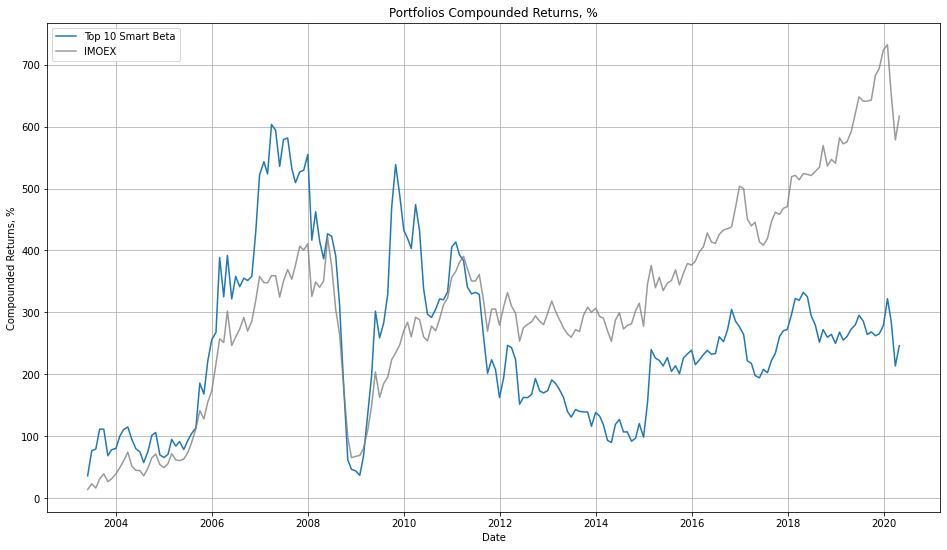

,Top 10 Smart Beta
"Total Return, %",246.22
"CAGR, %",7.58
"Mean Return, %",14.91* (1.56)
"Volatility, %",39.45
"Win Rate, %",50.49
"Mean Turnover, %",270.40
"Maximum Drawdown, %",-80.54
"Value at Risk, %",-54.72
"Expected Tail Loss, %",-75.69
"Expected Tail Reward, %",110.75


In [20]:
size_reversed = factorizer(1 / mcap, better="less")

builder_smart_beta_reversed = pqr.PortfolioBuilder(
    pqr.WeightsByFactor(size_reversed),
    pqr.TheoreticalAllocation()
)

top10_portfolio_smart_beta_reversed = builder_smart_beta_reversed(
    universe,
    longs=top10(size),
    name="Top 10 Smart Beta"
)

summary([top10_portfolio_smart_beta_reversed])

Отставание от бенчмарка увеличилось, при этом волатильность портфеля также сильно возросла. Грааль не найден :(

# Случайный тест

In [21]:
%%time
%%capture

zi = pqr.tests.ZeroIntelligenceTest(
    universe,
    builder,
    pqr.metrics.TrailingMeanReturn(),
    n=1000
)

zi_est = zi(best_portfolio)

CPU times: user 10.1 s, sys: 1.4 s, total: 11.5 s
Wall time: 11.5 s


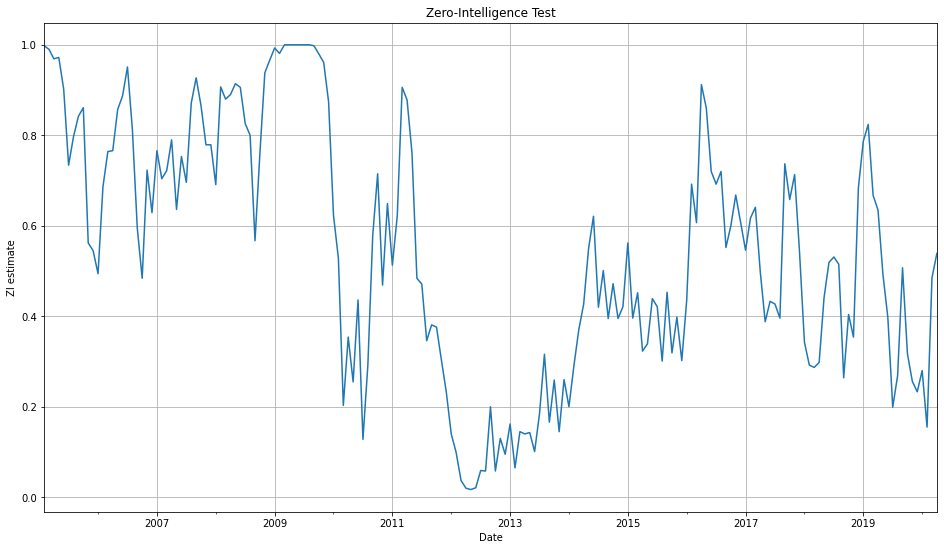

In [22]:
zi_est.plot()

plt.title("Zero-Intelligence Test")
plt.xlabel("Date")
plt.ylabel("ZI estimate")
plt.grid();